# Package

In [ ]:
# Numerical Operations
import math
import numpy as np 

import pandas as pd
import csv
import os

# torch
import torch
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.optim import Adam 
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from bisect import bisect_right

# For Progress Bar
from tqdm import tqdm

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100

import seaborn as sns
import statsmodels.stats.outliers_influence as sso
import math
import statistics
from scipy.optimize import curve_fit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
from PIL import Image
import os
import cv2
import pathlib

In [ ]:
normal_dataset_folder = os.path.join("/content/drive/My Drive/SLDL/COVID-19_Radiography_Dataset/Normal")
normal_dataset = pathlib.Path(normal_dataset_folder)
normal_images_dataset = list(normal_dataset.glob("images/*.*"))

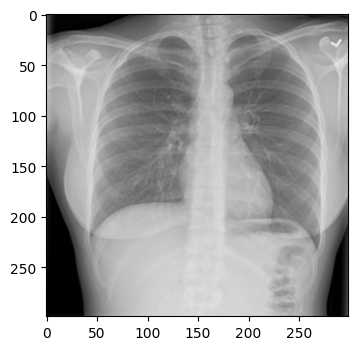

In [ ]:
l = normal_images_dataset[4]
img  = cv2.imread(str(l))
plt.imshow(img)
plt.show()

In [ ]:
covid_dataset_folder = os.path.join("/content/drive/My Drive/SLDL/COVID-19_Radiography_Dataset/COVID")
covid_dataset = pathlib.Path(covid_dataset_folder)
covid_images_dataset = list(covid_dataset.glob("images/*.*"))

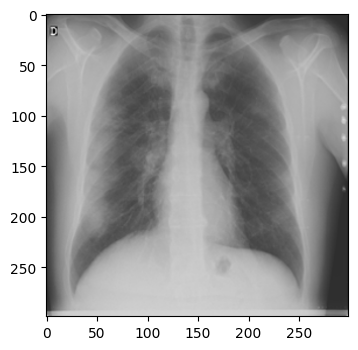

In [ ]:
l = covid_images_dataset[4]
img  = cv2.imread(str(l))
plt.imshow(img)
plt.show()

In [ ]:
def change_image_values(img):
  for i in range(48):
    for j in range(48):
      if img[i, j] <= 150:
        img[i, j] = 0
      elif img[i, j] > 150:
        img[i, j] = 1
  return img

In [ ]:
from skimage import color
normal_images = []
# t = 0
for i in normal_images_dataset[:3616]:
  # if t % 100 == 0 :
  #   print(t)
  # t = t+1
  img = cv2.imread(str(i))
  img = cv2.resize(img, (100, 100))
  normal_images.append(img)
  # normal_images.append(color.rgb2gray(img))
normal_images = np.array(normal_images) 
normal_images.shape

(3616, 100, 100, 3)

In [ ]:
covid_images = []
# t = 0
for i in covid_images_dataset[:3616]:
  # if t % 100 == 0:
  #   print(t)
  # t = t+1
  img = cv2.imread(str(i))
  img = cv2.resize(img, (100, 100))
  covid_images.append(img)
  # covid_images.append(color.rgb2gray(img))
covid_images = np.asarray(covid_images) 
covid_images.shape

(3616, 100, 100, 3)

In [ ]:
covid_y = np.ones(covid_images.shape[0])
print(covid_y.shape)
normal_y = np.zeros(normal_images.shape[0])
print(normal_y.shape)

(3616,)
(3616,)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #使用cuda來跑
config = {        #將可調動的參數集中設定
    'seed': 42,
    'test_ratio': 0.2,
    'valid_ratio': 0.2,
    'n_epochs': 50,           
    'batch_size': 100, 
    'learning_rate': 0.001,         
    'early_stop': 50,     
    'save_path': './models/model.ckpt',
    'T_0': 10,
    'T_mult':1
}

In [ ]:
# 參照其他課堂給的函數
def same_seed(seed):  #為了重覆獲得結果，固定random number
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed): #劃分training data和validation data
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def train_test_split(data_set, test_ratio, seed): #劃分training data和test data
    test_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - test_set_size
    train_set, test_set = random_split(data_set, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(test_set)

def predict(test_loader, model, device):
    model.eval() # Set the model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)            
            preds.append(pred.detach().cpu()) 
    preds = torch.cat(preds, dim=0).numpy()
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    return preds
def predict_prob(test_loader, model, device):
    model.eval() # Set the model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)            
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [ ]:
x_data = np.concatenate((covid_images, normal_images), axis = 0)
y_data = np.concatenate((covid_y, normal_y), axis = 0)
print(x_data.shape)
print(y_data.shape)

(7232, 100, 100, 3)
(7232,)


In [ ]:
np.random.seed(config['seed'])
shuffled_indices = np.random.permutation(x_data.shape[0])
x_data = x_data[shuffled_indices,:,:,:]
y_data = y_data[shuffled_indices]

In [ ]:
x_train_value_ori, x_test_value_ori = train_test_split(x_data, config['test_ratio'], config['seed'])
y_train_value, y_test_value = train_test_split(y_data, config['test_ratio'], config['seed'])

In [ ]:
print(x_train_value_ori.shape)
print(y_train_value.shape)

(5786, 100, 100, 3)
(5786,)


In [ ]:
x_train_value = np.zeros((x_train_value_ori.shape[0], x_train_value_ori.shape[3], x_train_value_ori.shape[1], x_train_value_ori.shape[2]))
for i in range(x_train_value_ori.shape[0]):
  for j in range(x_train_value_ori.shape[3]):
    x_train_value[i,j,:,:] = x_train_value_ori[i,:,:,j]
print(x_train_value.shape)

(5786, 3, 100, 100)


In [ ]:
import gc

del y_data, x_data, x_train_value_ori

gc.collect()

4675

In [ ]:
x_test_value = np.zeros((x_test_value_ori.shape[0], x_test_value_ori.shape[3], x_test_value_ori.shape[1], x_test_value_ori.shape[2]))
for i in range(x_test_value_ori.shape[0]):
  for j in range(x_test_value_ori.shape[3]):
    x_test_value[i,j,:,:] = x_test_value_ori[i,:,:,j]
print(x_test_value.shape)

(1446, 3, 100, 100)


In [ ]:
import gc

del x_test_value_ori

gc.collect()

0

# Normalization

In [ ]:
for i in range(x_train_value.shape[1]):
  for j in range(x_train_value.shape[2]):
    for k in range(x_train_value.shape[3]):
      x = np.array([x_train_value[:,i,j,k]]).T
      scaler1 = StandardScaler().fit(x)
      x_n = scaler1.transform(x)
      x_train_value[:,i,j,k] = x_n.reshape(x.shape[0])
      y = np.array([x_test_value[:,i,j,k]]).T
      y_n = scaler1.transform(y)
      x_test_value[:,i,j,k] = y_n.reshape(y.shape[0])

In [ ]:
class COVIDDataset():
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Build model

In [ ]:
class MyModule(nn.Module):
  def __init__(self, input_dim):
    super(MyModule, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(input_dim, 64, 3, 1, 1),  # [64, 100, 100]
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),      # [64, 50, 50]
        nn.Dropout2d(p=0.2),
        nn.Conv2d(64, 128, 3, 1, 1),  # [64, 50, 50]
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0), 
        nn.Dropout2d(p=0.2),      # [64,25,25]
        nn.Conv2d(128, 256, 3, 1, 1),  # [64, 25, 25]
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),       # [64,12,12]
        nn.Dropout2d(p=0.2)
    )
    self.fc = nn.Sequential(
            nn.Linear(256*12*12, 512),
            nn.ReLU(),
            # nn.Dropout(0.6),
            nn.Linear(512, 1)
        )

  def forward(self, x):
    out = self.cnn(x)
    out = out.view(out.size()[0], -1)
    
    return self.fc(out)


# Fit dataset

In [ ]:
# 將一整個訓練的過程定義成函數
def trainer(train_loader, valid_loader, model, config, device):
  
  #建立儲存model的資料夾
  if not os.path.isdir('./models'):
    os.mkdir('./models')

  # loss and optimizer
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay = 2e-4)
  #optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
  #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)

  scheduler = CosineAnnealingWarmRestarts(optimizer, config['T_0'], config['T_mult'])
  writer = SummaryWriter() # Writer of tensoboard.
  iters = len(train_loader)


  epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
  final_valid = []
  final_train = []
  learning_rate = []
  for epoch in range(epochs):
      model.train()
      train_loss = []

      # 用tqdm來看當前的進度
      # train_pbar = tqdm(train_loader, position=0, leave=True)
      i = 0
      print("第%d個epoch的學習率: %f" %(epoch+1, optimizer.param_groups[0]['lr']))
      learning_rate.append(optimizer.param_groups[0]['lr'])
      for x, y in train_loader:

        optimizer.zero_grad()               # Set gradient to zero.
        x, y = x.to(device), y.to(device)       # Move your data to device. 
        pred = model(x)             
        loss = criterion(pred, y)

        #L2 regression
        l2_lambda = 2e-3
        l2_norm = sum(p.pow(2.0).sum()for p in model.parameters())
        
        loss.backward()                  # Compute gradient(backpropagation).
        optimizer.step()                  # Update parameters.
        scheduler.step(epoch + i / iters)
        step += 1
        train_loss.append(loss.detach().item())
        
        # # Display current epoch number and loss on tqdm progress bar.
        # train_pbar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        # train_pbar.set_postfix({'loss': loss.detach().item()})
        i = i+1
      mean_train_loss = sum(train_loss)/len(train_loss)
      writer.add_scalar('Loss/train', mean_train_loss, step)

      # 預測 valid_y 並算出validation loss
      model.eval() # Set your model to evaluation mode.
      valid_loss = []
      for x, y in valid_loader:
          x, y = x.to(device), y.to(device)
          with torch.no_grad():
              pred = model(x)
              loss = criterion(pred, y)

          valid_loss.append(loss.item())
      
      mean_valid_loss = sum(valid_loss)/len(valid_loss)
      print(f'Epoch [{epoch+1}/{epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss : {mean_valid_loss:.4f}, Status [{early_stop_count}/{ 50 }], Best loss: {best_loss:.4f}')
      writer.add_scalar('Loss/valid', mean_valid_loss, step)

      #記錄每個epoch的train和validation loss
      final_train.append(mean_train_loss)
      final_valid.append(mean_valid_loss)
      #print("train len = ", len(final_train), "valid len = ", len(final_valid))

      if mean_valid_loss < best_loss:
          best_loss = mean_valid_loss
          torch.save(model.state_dict(), config['save_path']) # Save your best model
          print('Saving model with loss {:.3f}...'.format(best_loss))
          early_stop_count = 0
      if mean_train_loss < mean_valid_loss or mean_valid_loss >= best_loss: 
          early_stop_count += 1
      

      # 若持續一段時間沒更新，代表model收斂，則提前結束
      if early_stop_count >= config['early_stop'] or (optimizer.param_groups[0]['lr'] < 1e-6 and epoch > 200):
          print('\nModel is not improving, so we halt the training session.')
          print('best_loss = ', best_loss)
          return final_valid, final_train, learning_rate, epoch
  print('best_loss = ', best_loss)
  return final_valid, final_train, learning_rate, epochs

In [ ]:
# Set seed for reproducibility
same_seed(config['seed'])

x_train, x_valid = train_valid_split(x_train_value, config['valid_ratio'], config['seed'])
y_train, y_valid = train_valid_split(y_train_value, config['valid_ratio'], config['seed'])

del x_train_value, y_train_value

gc.collect()

np.random.seed(config['seed'])
shuffled_indices = np.random.permutation(x_train.shape[0])
x_train = x_train[shuffled_indices,:,:,:]
y_train = y_train[shuffled_indices]

# 將training data和validation data的x, y合併成一個data type，方便後續shuffle
train_dataset = COVIDDataset(x_train, y_train)
valid_dataset = COVIDDataset(x_valid, y_valid)
test_dataset = COVIDDataset(x_test_value)

del y_train, x_test_value

gc.collect()


# Pytorch data loader loads pytorch dataset into batches. pin_memory = True代表將生成的Tensor存於內存中，能較快轉到GPU
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [ ]:
# 使用trainer來跑模型
model = MyModule(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
valid_loss, train_loss, learning_rate, epoch = trainer(train_loader, valid_loader, model, config, device)

第1個epoch的學習率: 0.001000


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch [1/50]: Train loss: 390.2838, Valid loss : 0.3091, Status [0/50], Best loss: inf
Saving model with loss 0.309...
第2個epoch的學習率: 0.000977
Epoch [2/50]: Train loss: 0.2676, Valid loss : 0.2534, Status [1/50], Best loss: 0.3091
Saving model with loss 0.253...
第3個epoch的學習率: 0.000906
Epoch [3/50]: Train loss: 0.2575, Valid loss : 0.2687, Status [1/50], Best loss: 0.2534
第4個epoch的學習率: 0.000797
Epoch [4/50]: Train loss: 0.2580, Valid loss : 0.2524, Status [2/50], Best loss: 0.2534
Saving model with loss 0.252...
第5個epoch的學習率: 0.000658
Epoch [5/50]: Train loss: 0.2587, Valid loss : 0.2526, Status [1/50], Best loss: 0.2524
第6個epoch的學習率: 0.000503
Epoch [6/50]: Train loss: 0.2547, Valid loss : 0.2508, Status [2/50], Best loss: 0.2524
Saving model with loss 0.251...
第7個epoch的學習率: 0.000349
Epoch [7/50]: Train loss: 0.2521, Valid loss : 0.2520, Status [1/50], Best loss: 0.2508
第8個epoch的學習率: 0.000209
Epoch [8/50]: Train loss: 0.2526, Valid loss : 0.2513, Status [2/50], Best loss: 0.2508
第9個epoch

# Re-load best weight, and prediction test dataset

In [ ]:
model = MyModule(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 

100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


In [ ]:
preds_prob = predict_prob(test_loader, model, device)

100%|██████████| 15/15 [00:00<00:00, 25.72it/s]


# save test prediction, and plot figure

In [ ]:
data = {'Positive or not': np.reshape(preds,preds.shape[0])
    }

<function matplotlib.pyplot.show(*args, **kw)>

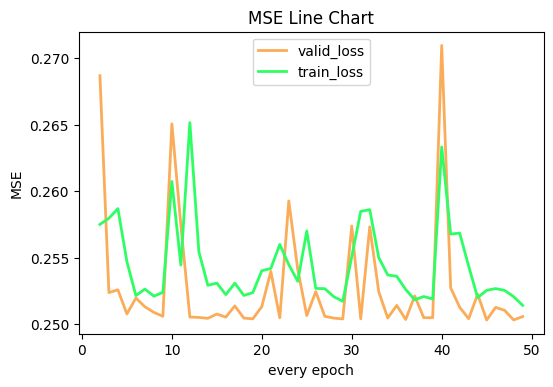

In [ ]:
df=pd.DataFrame({'epoch': np.arange(2,epoch),'valid_loss': valid_loss[2:epoch], 'train_loss': train_loss[2:epoch] })

plt.plot( 'epoch', 'valid_loss', data=df, color= '#FAAC58' , linewidth=2, label = "valid_loss")
plt.plot( 'epoch', 'train_loss', data=df, color= '#2EFE64' , linewidth=2, label = "train_loss")

plt.xlabel("every epoch")
plt.ylabel("MSE")
plt.title("MSE Line Chart")

plt.legend()

plt.show

In [ ]:
from sklearn import metrics
# testing data Accuracy, Precision, Recall, F-1 Score
f1_score = metrics.f1_score(y_test_value, preds)
accuracy = metrics.accuracy_score(y_test_value, preds)
Recall = metrics.recall_score(y_test_value, preds)
Precision = metrics.precision_score(y_test_value, preds)

print("F-1 Score:", f1_score)
print("Accuracy:", accuracy)
print("Recall:", Recall)
print("Precision", Precision)

F-1 Score: 0.612398246712586
Accuracy: 0.5719225449515906
Recall: 0.6936170212765957
Precision 0.5482062780269058


In [ ]:
ypredprob = predict_prob(test_loader, model, device) 
ypredprob_sort = ypredprob[ypredprob[:,0].argsort()[::-1]]
sort_id = ypredprob[:,0].argsort()[::-1]

100%|██████████| 15/15 [00:00<00:00, 26.11it/s]


In [ ]:
import itertools
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

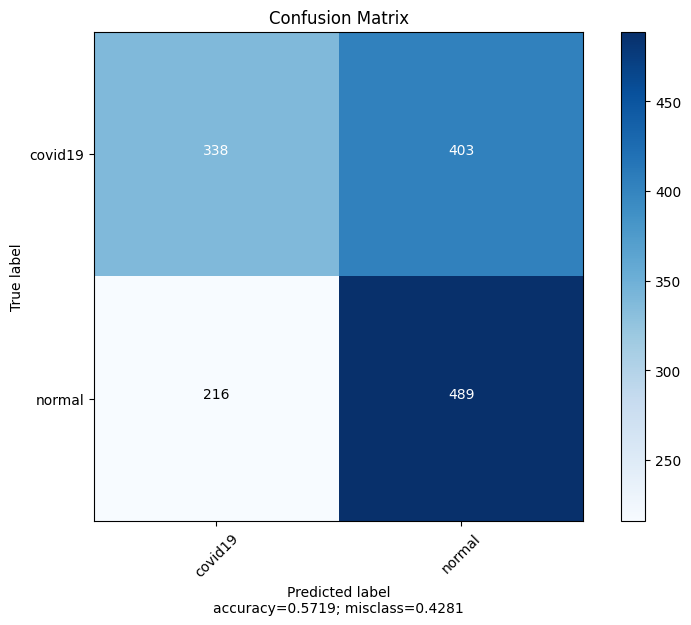

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_test_value, preds)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

# Upload Format

In [ ]:
df = pd.DataFrame.from_dict(data)  
df.index = df.index+1
df = df.reset_index()
df.to_csv('Result.csv', encoding = 'utf-8', index = False)